In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import random
from astropy.table import Table
from sklearn.inspection import permutation_importance

In [ ]:
"""
Args:
Retrun:
  lists for train data and test data
    - x-array: features
    - y-array: lables
    - indices: idx corresponding to row of orig data
  count_vectorizer (used to get a list of features later)
    - countvectorizer for x
    - countvectorizer for y
"""
def parse_data(filename):
    #load dataset
    joke = pd.read_csv(filename, sep=',')
    #preprocessing data
    X = joke.content
    y = joke.flattened_categories
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, range(len(X)), test_size = 0.2, random_state = 42)

    count_vect_x = CountVectorizer()
    count_vect_y = CountVectorizer()

    X_train = count_vect_x.fit_transform(X_train)
    X_test = count_vect_x.transform(X_test)
    y_train = count_vect_y.fit_transform(y_train)
    y_test = count_vect_y.transform(y_test)

    X_train_array = X_train.toarray()
    y_train_array = y_train.toarray()
    X_test_array = X_test.toarray()
    y_test_array = y_test.toarray()

    print(np.shape(X_train_array))
    print(np.shape(X_test_array))
    return [X_train_array, y_train_array, indices_train],\
           [X_test_array, y_test_array , indices_test],\
           count_vect_x, count_vect_y, indices_train, indices_test, joke.content

In [ ]:
"""
"""
def joke_to_X_array(joke, count_vect_x):
    X_array = count_vect_x.transform(pd.Series(joke))
    X_array = X_array.toarray()
    return X_array

In [ ]:
"""
This function predicts a set of categories of a given joke
the joke can be anything, doesn't have to be one from the dataset.
Args:
    joke: string of a joke
Return:
    predict_categories: list of categories a given joke falls into
"""
def predict_single_data(joke, classifier, count_vect_x, count_vect_y):
    label_names = count_vect_y.get_feature_names()
    X = joke_to_X_array(joke, count_vect_x)
    predict = classifier.predict(X)
    #print(np.shape(predict))
    predict_categories = []
    for i in range(len(label_names)):
        if predict[0][i] == 1:
            predict_categories.append(label_names[i])
    return predict_categories

In [ ]:
#def predict(y_test):
#    return categories

In [ ]:
"""
y_true: true lables (y_array)
y_pred: predict lales (y_array)
"""
def accuracy(y_true, y_pred):
    # list of accuracies of each row
    accuracies = np.array([])

    for i in range(len(y_true)):
        a1 = []
        a2 = []
        for j in range(len(y_true[0])):
            if y_true[i][j] == 1:
                a1.append(j)
            if y_pred[i][j] == 1:
                a2.append(j)
        similarity = len(set(a1) & set(a2)) / float(len(set(a1) | set(a2))) * 100
        accuracies = np.append(accuracies, similarity)
        
    #accuracy for all rows
    overall_accuracy = np.mean(accuracies)
    return overall_accuracy

In [ ]:
"""
Args:
  title
  x_name, X
  y_name
  y_list: [[y_name, y_array], [y_name, y_array], ...]
"""
def plot_line(title, x_name, X, y_name, y_list):
    fig, ax = plt.subplots()
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_title(title)
    for y in y_list:
        ax.plot(X, y[1], marker='o', label=y[0],
                drawstyle="steps-post")
    ax.legend()
    plt.show()

In [ ]:
#def main():
train, test, cv_x, cv_y, indices_train, indices_test, content = parse_data('comedy.csv')
X_train = train[0]
y_train = train[1]
indices_train = train[2]
X_test = test[0]
y_test = test[1]
indices_test = test[2]

#joke = 'I bought one of those tapes to teach you Spanish in your sleep. During the night, the tape skipped. Now I can only stutter in Spanish. Steven Wright'
#pred_categories = predict_single_data(joke, classifier_alpha, cv_x, cv_y)
#print(pred_categories)

#if __name__ == '__main__':
#    main()

(7308, 16099)
(1827, 16099)


In [ ]:
# no pruning
classifier = DecisionTreeClassifier()
classifier = classifier.fit(X_train, y_train)

y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

accuracy_test = accuracy(y_test, y_pred_test)
accuracy_train = accuracy(y_train, y_pred_train)

print('testing accuracy:', accuracy_test)
print('training accuracy:', accuracy_train)

testing accuracy: 39.76941283796785
training accuracy: 99.94526546250684


In [ ]:
pruning_path = classifier.cost_complexity_pruning_path(X_train, y_train)
effective_alphas = pruning_path['ccp_alphas']
impurities = pruning_path['impurities']
max_alpha = np.amax(effective_alphas)
min_alpha = np.amin(effective_alphas)
print('min alpha:', min_alpha)
print('max alpha:', max_alpha)

min alpha: 0.0
max alpha: 0.010277092840833543


In [ ]:
training_accuracies = []
testing_accuracies = []
x_a = []

for i in range(0, len(effective_alphas), int(len(effective_alphas)/10)):
  clf = DecisionTreeClassifier(ccp_alpha=effective_alphas[i])
  clf = clf.fit(X_train, y_train)
  prd_train = clf.predict(X_train)
  prd_test = clf.predict(X_test)

  training_accuracies.append(accuracy(y_train, prd_train))
  testing_accuracies.append(accuracy(y_test, prd_test))
  x_a.append(effective_alphas[i])

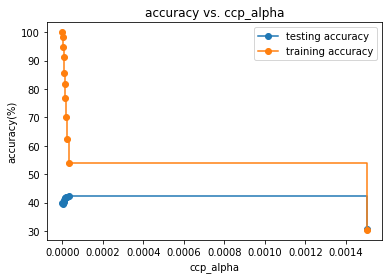

In [ ]:
plot_line("accuracy vs. ccp_alpha", "ccp_alpha", x_a, 'accuracy(%)',\
         [ ['testing accuracy', testing_accuracies], ['training accuracy', training_accuracies]])

In [ ]:
training_accuracies = []
testing_accuracies = []
x_a = []

for i in range(0, len(effective_alphas), int(len(effective_alphas)/10)):
  clf = DecisionTreeClassifier(ccp_alpha=effective_alphas[i])
  clf = clf.fit(X_train, y_train)
  prd_train = clf.predict(X_train)
  prd_test = clf.predict(X_test)

  tr_a = f1_score(y_train, prd_train, average='micro')
  te_a = f1_score(y_test, prd_test, average='micro')
  training_accuracies.append(tr_a)
  testing_accuracies.append(te_a)
  x_a.append(effective_alphas[i])

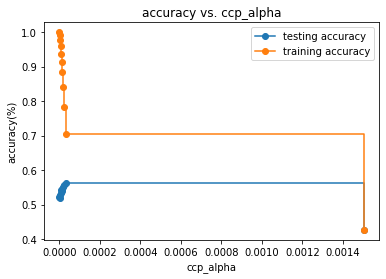

In [ ]:
plot_line("accuracy vs. ccp_alpha", "ccp_alpha", x_a, 'accuracy(%)',\
         [ ['testing accuracy', testing_accuracies], ['training accuracy', training_accuracies]])

In [ ]:
training_accuracies2 = []
testing_accuracies2 = []
x_a2 = []

j = 0
while j < len(effective_alphas) and effective_alphas[j] < 0.00005:
  clf = DecisionTreeClassifier(ccp_alpha=effective_alphas[j])
  clf = clf.fit(X_train, y_train)
  prd_train = clf.predict(X_train)
  prd_test = clf.predict(X_test)

  training_accuracies2.append(accuracy(y_train, prd_train))
  testing_accuracies2.append(accuracy(y_test, prd_test))
  x_a2.append(effective_alphas[j])
  j = j + int(len(effective_alphas)/10)

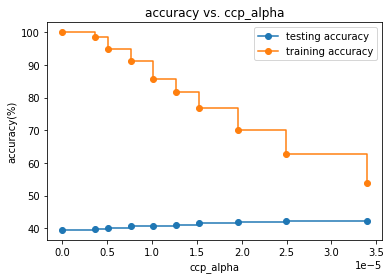

In [ ]:
plot_line("accuracy vs. ccp_alpha", "ccp_alpha", x_a2, 'accuracy(%)',\
         [ ['testing accuracy', testing_accuracies2], ['training accuracy', training_accuracies2]])

In [ ]:
training_accuracies4 = []
testing_accuracies4 = []
x_a4 = []

j = 0
while j < len(effective_alphas) and effective_alphas[j] < 0.00005:
  clf = DecisionTreeClassifier(ccp_alpha=effective_alphas[j])
  clf = clf.fit(X_train, y_train)
  prd_train = clf.predict(X_train)
  prd_test = clf.predict(X_test)

  tr_a = f1_score(y_train, prd_train, average='micro')
  te_a = f1_score(y_test, prd_test, average='micro')
  training_accuracies4.append(tr_a)
  testing_accuracies4.append(te_a)
  x_a4.append(effective_alphas[j])
  j = j + int(len(effective_alphas)/10)

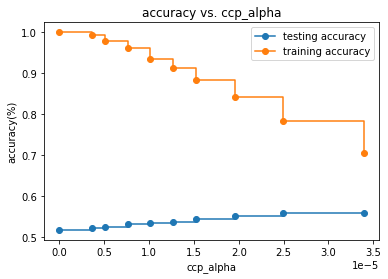

In [ ]:
plot_line("accuracy vs. ccp_alpha", "ccp_alpha", x_a4, 'accuracy(%)',\
         [ ['testing accuracy', testing_accuracies4], ['training accuracy', training_accuracies4]])

In [ ]:
num_nodes = classifier.tree_.node_count
classifier2 = DecisionTreeClassifier(min_samples_leaf=int(num_nodes*0.005))
classifier2 = classifier2.fit(X_train, y_train)

y_pred_test2 = classifier2.predict(X_test)
y_pred_train2 = classifier2.predict(X_train)

accuracy_test2 = accuracy(y_test, y_pred_test2)
accuracy_train2 = accuracy(y_train, y_pred_train2)

print('testing accuracy:', accuracy_test2)
print('training accuracy:', accuracy_train2)

testing accuracy: 36.91489453804725
training accuracy: 37.586833702391985


In [ ]:
"""
importance = classifier.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

result = permutation_importance(classifier, X_train, y_train, n_repeats=1)
print(result)
print(classifier.feature_importances_)
"""

"\nimportance = classifier.feature_importances_\nfor i,v in enumerate(importance):\n\tprint('Feature: %0d, Score: %.5f' % (i,v))\nplt.bar([x for x in range(len(importance))], importance)\nplt.show()\n"

In [ ]:
# ccp_alpha = 0.000025
classifier_alpha = DecisionTreeClassifier(ccp_alpha=0.000025)
classifier_alpha = classifier_alpha.fit(X_train, y_train)

y_pred_test_alpha = classifier_alpha.predict(X_test)
y_pred_train_alpha = classifier_alpha.predict(X_train)

accuracy_test_alpha = accuracy(y_test, y_pred_test_alpha)
accuracy_train_alpha = accuracy(y_train, y_pred_train_alpha)

print('testing accuracy:', accuracy_test_alpha)
print('training accuracy:', accuracy_train_alpha)

testing accuracy: 41.991032746369356
training accuracy: 62.34704559109321


In [ ]:
print(f1_score(y_test, y_pred_test_alpha, average='micro'))

0.5536224004349599


In [ ]:
# ccp_alpha = 0.0000284
classifier_alpha2 = DecisionTreeClassifier(ccp_alpha=0.0000284)
classifier_alpha2 = classifier_alpha2.fit(X_train, y_train)

y_pred_test_alpha2 = classifier_alpha2.predict(X_test)
y_pred_train_alpha2 = classifier_alpha2.predict(X_train)

accuracy_test_alpha2 = accuracy(y_test, y_pred_test_alpha2)
accuracy_train_alpha2 = accuracy(y_train, y_pred_train_alpha2)

print('testing accuracy:', accuracy_test_alpha2)
print('training accuracy:', accuracy_train_alpha2)

testing accuracy: 42.34450268063714
training accuracy: 58.871345122371395


In [ ]:
print(f1_score(y_test, y_pred_test_alpha2, average='micro'))

0.5600220264317181


In [ ]:
idx = np.random.choice(len(y_test), 3, replace=False)

pred_labels_ = []
true_labels_ = []
similarities = []

for i in idx:
  t = []
  p = []
  for j in range(len(true_labels[0])):
    if true_labels[i][j] == 1:
      t.append(features[j])
    if pred_test[i][j] == 1:
      p.append(features[j])
  true_labels_.append(t)
  pred_labels_.append(p)
  similarity = len(set(p) & set(t)) / float(len(set(p) | set(t))) * 100
  similarities.append(similarity)

t = Table([indices_test, true_labels_, pred_labels_, similarities], names=('idx', 'true_label', 'predict', 'accuracy(%)'))
t

In [ ]:
idx = random.randrange(10)  
idx_in_X = indices_test[idx]
j = content[idx_in_X]
#pr = ct_single_data(j, classifier_alpha2, cv_x, cv_y)
pr = []
tr = []
labels = cv_y.get_feature_names()
for i in range(len(labels)):
    if y_test[idx][i] == 1:
      tr.append(labels[i])
    if y_pred_test_alpha2[idx][i] == 1:
      pr.append(labels[i])
#ac = f1_score(y_test[idx], y_pred_test_alpha2[idx], average='macro')
ac = len(set(pr) & set(tr)) / float(len(set(pr) | set(tr))) * 100

print('row #:', idx_in_X+2)
print('joke:', j)
print('true label:', tr)
print('predicted label:', pr)
print('accuracy:', ac)
print(f1_score(y_test[idx], y_pred_test_alpha2[idx], average='macro'))

#t = Table([[idx_in_X], [cv_y.get_feature_names()[idx]],[pr], [ac]], names=('idx', 'true_label', 'predict', 'accuracy(%)'))
#t

row #: 2837
joke: What is the difference between a pickpocket and a gynecologist?A pickpocket snatches watches and a gynecologist watches snatches.
true label: ['dirty', 'doctor', 'men', 'miscellaneous', 'women']
predicted label: ['miscellaneous']
accuracy: 20.0
0.6470588235294118


In [ ]:
pr = predict_single_data("My wife accused me of being immature. I told her too get out of my fort.", classifier_alpha2, cv_x, cv_y)
print(pr)

['dirty', 'lines', 'miscellaneous', 'pick', 'up']


In [ ]:
# find the best max_depth given cpp_alpha=0.0000284
depth = classifier_alpha2.tree_.max_depth
x_depth = np.arange(1, depth+1, 20)
training_accuracies = []
testing_accuracies = []

for d in range(1, depth+1, 20):
    clf = DecisionTreeClassifier(max_depth=d, ccp_alpha=0.0000284)
    clf = clf.fit(X_train, y_train)
    prd_train = clf.predict(X_train)
    prd_test = clf.predict(X_test)

    training_accuracies.append(accuracy(y_train, prd_train))
    testing_accuracies.append(accuracy(y_test, prd_test))

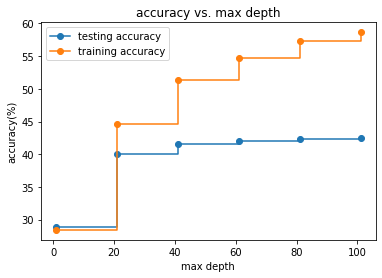

In [ ]:
plot_line("accuracy vs. max depth", 'max depth', x_depth, 'accuracy(%)',\
         [ ['testing accuracy', testing_accuracies], ['training accuracy', training_accuracies]])

In [ ]:
# ccp_alpha=0.0000284, max_depth=40
clf_ = DecisionTreeClassifier(max_depth=120, ccp_alpha=0.0000284)
clf_ = clf_.fit(X_train, y_train)

y_pred_test_ = clf_.predict(X_test)
y_pred_train_ = clf_.predict(X_train)

accuracy_test_ = accuracy(y_test, y_pred_test_)
accuracy_train_ = accuracy(y_train, y_pred_train_)

print('testing accuracy:', accuracy_test_)
print('training accuracy:', accuracy_train_)
#print('testing accuracy_socre', accuracy_score(y_test, y_pred_test_))

testing accuracy: 42.394952367786324
training accuracy: 58.96874574522357
